In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# %pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Flatten,
    Concatenate,
    Multiply,
    Attention,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-06-09 23:42:04.327070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [ ]:
# users.head(10)

In [ ]:
# items.head()

In [ ]:
# ratings.head()

In [3]:
# Dropping the header row
users.drop(users.index[0], inplace=True)
items.drop(items.index[0], inplace=True)
ratings.drop(ratings.index[0], inplace=True)

In [ ]:
# users.head()

In [ ]:
# items.head()

In [ ]:
# ratings.head()

In [4]:
# Merge the three forms of data
df = pd.merge(users, ratings, on="user_id")

df = pd.merge(items, df, on="isbn")
# df.head()

In [ ]:
# df.shape

In [ ]:
# df.describe()

In [ ]:
# df.info()

In [5]:
# Check for missing values
df.isnull().sum()

isbn                        0
book_title                  0
book_author                 2
year_of_publication         0
publisher                   2
img_s                       0
img_m                       0
img_l                       0
user_id                     0
location                    0
age                    277845
rating                      0
dtype: int64

In [6]:
# Drop the missing values
df.dropna(inplace=True)
df.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_s                  0
img_m                  0
img_l                  0
user_id                0
location               0
age                    0
rating                 0
dtype: int64

In [ ]:
# df.info()

In [7]:
# Convert the data types
df["user_id"] = df["user_id"].astype(int)
df["isbn"] = df["isbn"].astype(str)
df["rating"] = df["rating"].astype(float)
df["year_of_publication"] = df["year_of_publication"].astype(int)

In [8]:
# Re-index user_id and isbn
user_id_mapping = {id: idx for idx, id in enumerate(df["user_id"].unique())}
isbn_mapping = {isbn: idx for idx, isbn in enumerate(df["isbn"].unique())}

df["user_id"] = df["user_id"].map(user_id_mapping)
df["isbn"] = df["isbn"].map(isbn_mapping)

In [ ]:
# # Authors with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=df['book_author'].value_counts().head(50), y=df['book_author'].value_counts().head(50).index)
# plt.xlabel("Count")
# plt.ylabel("Author")
# plt.title("Authors with Most Ratings", size=20)

In [ ]:
# ds = df["book_title"].value_counts().head(50).reset_index()
# ds.columns = ["book", "count"]
# ds.head()

In [ ]:
# # Books with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=ds['count'], y=ds['book'])
# plt.xlabel("Count")
# plt.ylabel("Book")
# plt.title("Books with Most Ratings", size=20)

# Split the dataset into training, validation, and test sets

In [9]:
# Split the dataset into training, validation, and test sets
# Splits the original dataset df into two parts: 80% of the data is assigned to train, and 20% is assigned to test.
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Splits the train dataset into two parts: 80% of the data is assigned to train, and 20% is assigned to val.
train, val = train_test_split(train, test_size=0.2, random_state=42)
# In the end, we have train: 64% of the original dataset, val: 16% of the original dataset, test: 20% of the original dataset.

In [10]:
# Extracting the input arrays
user_ids_train = train["user_id"].values
item_ids_train = train["isbn"].values
ratings_train = train["rating"].values.astype(float)
user_ids_val = val["user_id"].values
item_ids_val = val["isbn"].values
ratings_val = val["rating"].values.astype(float)

In [11]:
# Verify data types and ranges
print(user_ids_train.dtype)  # Should be integer type
print(item_ids_train.dtype)  # Should be integer type
print(ratings_train.dtype)  # Should be float type

print(
    user_ids_train.max(), len(user_id_mapping)
)  # Max value should be less than len(user_id_mapping)
print(
    item_ids_train.max(), len(isbn_mapping)
)  # Max value should be less than len(isbn_mapping)

int64
int64
float64
53887 53888
229011 229012


In [12]:
# Matrix Factorization with Neural Networks (MF-NN)
# This leverages collaborative filtering with deep learning for user-item interaction modeling.


# Define MF-NN Model
def mf_nn_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    concat = Concatenate()([user_vector, item_vector])

    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(concat)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model

In [13]:
num_users = len(user_id_mapping)
num_items = len(isbn_mapping)
# This is the dimension of the embedding vectors for both users and items.
# It determines the size of the latent factors space where users and items are projected. A higher dimension can capture more complex interactions but also increases the computational complexity and risk of overfitting.
embedding_dim = 50 #TODO: Experiment with lower number

In [14]:
# Train the MF-NN model
model_mf_nn = mf_nn_model(num_users, num_items, embedding_dim)
# model_mf_nn.summary()

In [15]:
# Callbacks for better training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_mf_nn.fit(
    [user_ids_train, item_ids_train],
    ratings_train,
    epochs=50,  # Increased number of epochs for monitoring
    batch_size=32,
    validation_data=([user_ids_val, item_ids_val], ratings_val),
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4722s 313ms/step - loss: 15.1282 - val_loss: 13.6225 - learning_rate: 0.0010
Epoch 2/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4812s 319ms/step - loss: 13.3081 - val_loss: 13.1030 - learning_rate: 0.0010
Epoch 3/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4868s 323ms/step - loss: 13.0574 - val_loss: 13.1078 - learning_rate: 0.0010
Epoch 4/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 4722s 313ms/step - loss: 13.0036 - val_loss: 13.1154 - learning_rate: 0.0010
Epoch 5/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2788s 185ms/step - loss: 12.9620 - val_loss: 12.9857 - learning_rate: 0.0010
Epoch 6/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2798s 186ms/step - loss: 12.9611 - val_loss: 12.8573 - learning_rate: 0.0010
Epoch 7/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2785s 185ms/step - loss: 12.8717 - val_loss: 13.1066 - learning_rate: 0.0010
Epoch 8/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2800s 186ms/step - loss: 12.8949 - val_loss: 12.6980 - learning_rate: 0.0010
Epoch 9/50
15067/15067 ━━━━━━━━━

In [43]:
model_mf_nn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │  2,694,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │ 11,450,600 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,498,749 (162.12 MB)

 Trainable params: 14,166,249 (54.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,332,500 (108.08 MB)

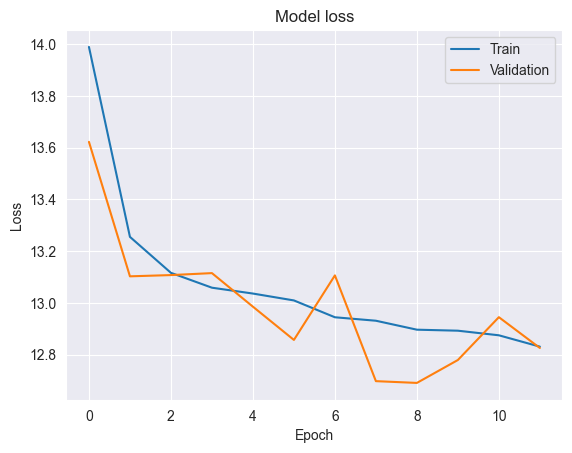

In [16]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [17]:
# Evaluate and compare performance on test set
user_ids_test = test["user_id"].astype(int).values
item_ids_test = test["isbn"].astype(int).values
ratings_test = test["rating"].astype(float).values
test_loss = model_mf_nn.evaluate(
    [user_ids_test, item_ids_test], ratings_test
)
print(f"Test Loss: {test_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 95s 20ms/step - loss: 12.6571
Test Loss: 12.715423583984375


In [18]:
# Evaluate on the validation set
val_loss = model_mf_nn.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 79s 21ms/step - loss: 12.7315
Validation Loss: 12.691157341003418


In [19]:
# Optionally, predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_mf_nn.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_mf_nn.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Prediction Validation: [[1.005779 ]
 [0.8545165]
 [1.2354383]
 ...
 [2.3584137]
 [2.633078 ]
 [1.1504891]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Prediction Test: [[0.90699416]
 [1.4482198 ]
 [3.1297088 ]
 ...
 [3.9339182 ]
 [2.0297492 ]
 [0.71745145]]
Validation RMSE: 3.4087948223780953, Test RMSE: 3.4123492103757145


# Book Recommendation

In [20]:
# Choose a user ID (e.g., randomly select one from the dataset)
# user_id = df["user_id"].sample(1).values[0]
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val['user_id'] == user_id].index
user_val_items = val.loc[user_val_indices, 'isbn'].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val['isbn'].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_mf_nn.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame({'isbn': user_not_interacted_items, 'predicted_rating': predictions_pred.flatten()})

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(by='predicted_rating', ascending=False).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[top_n_recommendations['isbn'], ['book_title', 'book_author']]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)



2130/2130 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Top 10 Recommended Books for User 3885
                                             book_title          book_author
5225        Garzanti - Gli Elefanti: Creatura Di Sabbia        T Ben Jelloun
2015  Afrikanisches Fieber. Erfahrungen aus vierzig ...  Ryszard Kapuscinski
5161  Dana and the Calendar Man (Harlequin American ...        Hiram Bingham
1683                               I Capture the Castle          Dodie Smith
26                             Flood : Mississippi 1927        Kathleen Duey
3642                                       Life Penalty         Joy Fielding
5160    Tapestry Of Fate (Harlequin Historical, No 246)        Nina Beaumont
6025                A Grave Denied: A Kate Shugak Novel        Dana Stabenow
700                                          I And Thou         Martin Buber
617   The Diary of Jack the Ripper/the Discovery, th...                 Jack


# NCF with Attention Model

In [21]:
import random
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds(42)

In [29]:
from tensorflow.keras.layers import Reshape, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def ncf_attention_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    interaction = Multiply()([user_vector, item_vector])

    # Reshape interaction tensor for compatibility with Attention layer
    interaction_reshaped = Reshape((1, embedding_dim))(interaction)

    attention = Attention()([interaction_reshaped, interaction_reshaped])
    attention_vector = Flatten()(attention)

    dense = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(attention_vector)
    dense = Dropout(0.3)(dense)
    dense = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(dense)
    dense = Dropout(0.3)(dense)
    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense)
    dense = Dropout(0.3)(dense)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    dense = Dropout(0.3)(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    return model

In [45]:
# Create the model
model = ncf_attention_model(num_users, num_items, embedding_dim)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 50)     │  2,694,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 50)     │ 11,450,600 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 50)        │          0 │ embedding_10[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 50)        │          0 │ embedding_11[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 50)        │          0 │ flatten_14[0][0], │
│ (Multiply)          │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 50)     │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 1, 50)     │          0 │ reshape_4[0][0],  │
│ (Attention)         │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 50)        │          0 │ attention_4[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │     26,112 │ flatten_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    131,328 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     32,896 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,343,657 (54.72 MB)

 Trainable params: 14,343,657 (54.72 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the NCF Attention model
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Set up learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train the model
history = model.fit(
    [train['user_id'], train['isbn']],
    train['rating'],
    validation_data=([val['user_id'], val['isbn']], val['rating']),
    epochs=30,
    batch_size=512,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 25.5393

/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


942/942 ━━━━━━━━━━━━━━━━━━━━ 216s 227ms/step - loss: 25.5308 - val_loss: 15.0054 - learning_rate: 0.0010
Epoch 2/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 205s 218ms/step - loss: 15.0835 - val_loss: 14.9592 - learning_rate: 0.0010
Epoch 3/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 207s 220ms/step - loss: 15.0364 - val_loss: 14.9517 - learning_rate: 0.0010
Epoch 4/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 205s 218ms/step - loss: 15.0090 - val_loss: 14.9490 - learning_rate: 0.0010
Epoch 5/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 194s 206ms/step - loss: 14.9963 - val_loss: 14.9470 - learning_rate: 0.0010
Epoch 6/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 195s 207ms/step - loss: 14.9808 - val_loss: 14.9421 - learning_rate: 0.0010
Epoch 7/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 203s 215ms/step - loss: 14.9746 - val_loss: 14.9416 - learning_rate: 0.0010
Epoch 8/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 205s 217ms/step - loss: 14.9633 - val_loss: 14.9376 - learning_rate: 0.0010
Epoch 9/30
942/942 ━━━━━━━━━━━━━━━━━━━━ 207s 220ms/step - loss: 14.9630 - val_loss:

In [42]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 50)     │  2,694,400 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 50)     │ 11,450,600 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 50)        │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 50)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 50)        │          0 │ flatten_8[0][0],  │
│ (Multiply)          │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 50)     │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 1, 50)     │          0 │ reshape_2[0][0],  │
│ (Attention)         │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 50)        │          0 │ attention_2[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │     26,112 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,030,973 (164.15 MB)

 Trainable params: 14,343,657 (54.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,687,316 (109.43 MB)

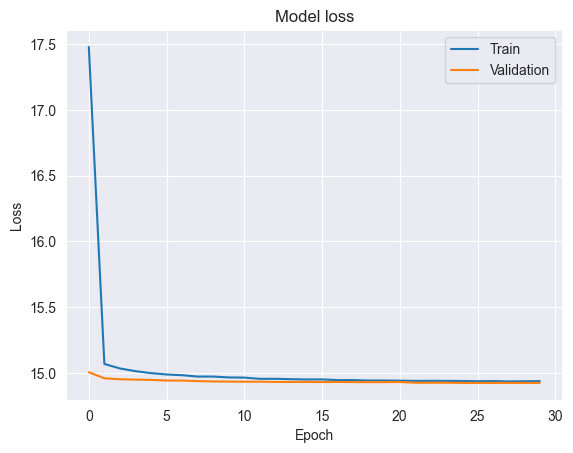

In [32]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [36]:
# Evaluate and compare performance on test set
model_ncf=model

# Ensure the test data is in the correct shape and type
user_ids_test = test["user_id"].astype(np.int32).values.reshape(-1, 1)
item_ids_test = test["isbn"].astype(np.int32).values.reshape(-1, 1)
ratings_test = test["rating"].astype(np.float32).values

# Evaluate the model on the test data
test_loss = model_ncf.evaluate([user_ids_test, item_ids_test], ratings_test)
print(f"Test Loss: {test_loss}")


/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4709/4709 ━━━━━━━━━━━━━━━━━━━━ 144s 30ms/step - loss: 14.9673
Test Loss: 14.93972110748291


In [39]:
# Ensure the validation data is in the correct shape and type
user_ids_val = test["user_id"].astype(np.int32).values.reshape(-1, 1)
item_ids_val = test["isbn"].astype(np.int32).values.reshape(-1, 1)
ratings_val = test["rating"].astype(np.float32).values

# Evaluate on the validation set
val_loss = model_ncf.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 145s 31ms/step - loss: 14.9673
Validation Loss: 14.93972110748291


In [40]:
# Predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4699/4709 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4709/4709 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step
Prediction Validation: [[2.756832]
 [2.756832]
 [2.756832]
 ...
 [2.756832]
 [2.756832]
 [2.756832]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step
Prediction Test: [[2.756832]
 [2.756832]
 [2.756832]
 ...
 [2.756832]
 [2.756832]
 [2.756832]]
Validation RMSE: 3.8650900344922685, Test RMSE: 3.8650900344922685


# Book Recommendations

In [41]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val["user_id"] == user_id].index
user_val_items = val.loc[user_val_indices, "isbn"].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val["isbn"].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame(
    {"isbn": user_not_interacted_items, "predicted_rating": predictions_pred.flatten()}
)

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(
    by="predicted_rating", ascending=False
).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[
    top_n_recommendations["isbn"], ["book_title", "book_author"]
]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)


/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2127/2130 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
Top 10 Recommended Books for User 3885
                                               book_title          book_author
1                                     Classical Mythology   Mark P. O. Morford
117034  Bountiful Women: Large Women's Secrets for Liv...       Bonnie Bernell
116981                                        Kurt Cobain          Kurt Cobain
116985  La MÃ?Â©thode simple pour en finir avec la cig...           Allen Carr
116992                        Easy Cooking for One or Two        Louise Davies
116993                              Nightfire (Heartfire)           Leona Karr
116996                      Starlight (Heartfire Romance)  Gloria Dale Skinner
117005                         The Old Contemptibles-O.M.        Martha Grimes
117007                                        The Bargain         Jane Ashford
117016                                The World of Jeeves       P.G. Wodehouse
